In [ ]:
#default_exp exhaustive_training

# 70-exhaustive-training
> Create systematic testing procedure and document conclusions

**Purpose**  The purpose of this notebook is to provide comprehensive testing with respect to:
1. Hyper-parameters (learning rate, dropout rate, compounding, etc)
2. Training data: this includes varying language (Spanish, Portuguese) and record type (baptismal, burial, and marriage)

In [ ]:
#no_test

#data structure imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

#python imports
import random

#modeling imports
from spacy.util import fix_random_seed
from ssda_nlp.collate import *
from ssda_nlp.split_data import *
from ssda_nlp.modeling import *
from ssda_nlp.preprocessing import *
from ssda_nlp.model_performance_utils import *

In [ ]:
#no_test
#if you want the same model everytime:
seed = 2436
random.seed(seed)
fix_random_seed(seed)

# Available Training Data
    1. 15834_annot.jsonl:                Baptism, Cuba
    2. 239746_annot.jsonl:               Baptism, Florida
    3. 419324_annot.jsonl:               Baptism, Colombia
    4. 701075_annot.jsonl:               Baptism, Brazil
    5. deathandbirthdata.jsonl:          50-50 Portuguese-Spanish, 75-25 burial-baptism
    6. guatemala.annotations.jsonl:      Burial, Spanish

Note that by using "df.sample(frac = x)" we can automatically get x percentage of the df, and pandas automatically shuffles the df before taking the fractional portion (also note that the original df is not affected).

In [ ]:
#no_test
#OUTPUT MUST BE COLLATED_DF

cdf1 = prodigy_output_to_collated_df("transcriptions/15834_annot.jsonl")
cdf2 = prodigy_output_to_collated_df("transcriptions/239746_annot.jsonl")
cdf3 = prodigy_output_to_collated_df("transcriptions/419324_annot.jsonl")
cdf4 = prodigy_output_to_collated_df("transcriptions/701075_annot.jsonl")
burialsMixed = prodigy_output_to_collated_df("transcriptions/deathandbirthdata.jsonl")
burialsOnly = prodigy_output_to_collated_df("transcriptions/guatemala.annotations.jsonl")

print(cdf1.shape)
print(cdf2.shape)
print(cdf3.shape)
print(cdf4.shape)
print(burialsMixed.shape)
print(burialsOnly.shape)

#Models I want to train:
#Vary Spanish-Portuguese concentrations
#Spanish: ~12000
#Portuguese: ~5000

#Vary Burial-baptism
#Baptism: ~13000
#Burial: ~5000

#Note that large variations are expected for burial-baptism since burial will 
#... only be a random sample, so just assuming 50% split
training_log = [0] * 12
for i in range(1,11):
    mixed_df = burialsMixed.sample(frac = i/10) 
    
    if (i == 1):
        #Save an additional test where we also include the full Burials in our training data
        collated_df = cdf3.append(mixed_df, ignore_index=True)
        collated_df = collated_df.append(burialsOnly, ignore_index=True)
        train_df, valid_df, test_df = split_data_grp(collated_df, prop_train = 0.7, prop_validation = 0.2, grp_var = 'entry_no', seed=seed)
        # Generate Spacy datasets
        train_spacy = genSpaCyInput(train_df)
        training_log[10] = train_spacy

    elif i== 10: #ie either edge case
        #Save an additional test where we also include the full Burials in our training data
        collated_df = cdf3.append(mixed_df, ignore_index=True)
        collated_df = collated_df.append(burialsOnly, ignore_index=True)
        train_df, valid_df, test_df = split_data_grp(collated_df, prop_train = 0.7, prop_validation = 0.2, grp_var = 'entry_no', seed=seed)
        # Generate Spacy datasets
        train_spacy = genSpaCyInput(train_df)
        training_log[11] = train_spacy

    collated_df = cdf3.append(mixed_df, ignore_index=True)
    # Split data
    train_df, valid_df, test_df = split_data_grp(collated_df, prop_train = 0.7, prop_validation = 0.2, grp_var = 'entry_no', seed=seed)
    # Generate Spacy datasets
    train_spacy = genSpaCyInput(train_df)
    training_log[i-1] = train_spacy

(2206, 6)
(2839, 6)
(947, 6)
(2809, 6)
(5796, 6)
(2040, 6)


In [ ]:
#no_test

# Split data
train_df, valid_df, test_df = split_data_grp(collated_df, prop_train = 0.7, prop_validation = 0.2, grp_var = 'entry_no', seed=seed)
# Generate Spacy datasets
train_spacy = genSpaCyInput(train_df)
# Look at column names
print(train_df.shape)
train_df = train_df.drop('entry_no',axis=1)
train_df.drop_duplicates(inplace=True)
print(train_df.shape)
pd.set_option("display.max_rows", None, "display.max_columns", None)
display(train_df.head()) #1000000
#train_df.loc[train_df['start'] == 401] #Returns the wrong ent
#train_df.loc[train_df['end'] == 409] #Returns nothing

(4612, 6)
(4155, 5)


,text,entity,start,end,label
0,Partida 8236 En esta Santa Iglecia de Santa Cr...,Santa Iglecia de Santa Cruz de Lorica,21,58,LOCATION
1,Partida 8236 En esta Santa Iglecia de Santa Cr...,veinte de Mayo de mil ochocien tos ochenta y c...,61,111,DATE
2,Partida 8236 En esta Santa Iglecia de Santa Cr...,José Maria Lugo,129,144,PERSON
3,Partida 8236 En esta Santa Iglecia de Santa Cr...,Eva Justina,182,193,PERSON
4,Partida 8236 En esta Santa Iglecia de Santa Cr...,cuatro de Febrero,207,224,DATE


In [ ]:
#no_test

nlp = load_model()

for text, annots in train_spacy:
    if "[margin]: Fran.co esc.o Domingo dos de Marco" in text:
        print(spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), annots["entities"]))

In [ ]:
print(training_data)

[('Martelo Partida 8237 En esta Santa Iglecia de Santa Cruz de Lorica á veinte de Mayo de mil ochocien tos ochenta y cinco, yo el Presbitero José Maria Lugo Cura Rector, bautisé solemne mente á Candelaria Catalina que nació el Treinta de Marzo ultimo, hija legitima de Anibal Martelo y Julia Prieto, sus abuelos paternos son Manuel José Mar telo y Juana Berrocal, y maternos  Juaquin Prieto y Juana de Dios Prieto, sien do sus padrinos Alberto Martines y Librada Martelo, aquienes les adverti las obligaciones del parentesco espiritual. El Cura Rector,  José Maria Lugo', {'entities': [(29, 66, 'LOCATION'), (69, 120, 'DATE'), (138, 153, 'PERSON'), (191, 214, 'PERSON'), (224, 240, 'DATE'), (247, 253, 'RELATIONSHIPS'), (254, 262, 'CHARACTERISTICS'), (266, 280, 'PERSON'), (283, 295, 'PERSON'), (301, 317, 'RELATIONSHIPS'), (318, 342, 'PERSON'), (345, 360, 'PERSON'), (363, 371, 'RELATIONSHIPS'), (373, 387, 'PERSON'), (390, 410, 'PERSON'), (424, 432, 'RELATIONSHIPS'), (433, 449, 'PERSON'), (452, 46

# Training Block
> Three stages:
1. Run lots of trials varying learning rate and dropout, get a sense of what ranges might be the best
2. Repeat the above, but focused in on the identified areas
3. Repeat, but instead of varying hyper parameters, vary the training data

In [ ]:
#no_test

#if you want the same model everytime:
#random.seed(seed)
#fix_random_seed(seed)

#spacy parameters
for training_data in training_log:
    print(training_data[1])
    print('-------')
    cping = {'start':16, 'end':32, 'cp_rate':1.05}
    solves = {'learn_rate':0.001} #Original 0.001
    dpout = 0.5 #Original 0.6
    save_mdir = 'models/exhaustive_models'

    #load model from pretrained
    nlp_model = load_model()

    nlp_model, perf_df = model_meta_training(nlp_model, training_data, valid_df, verbose=True, save_dir = save_mdir,
                                             n_iter=10, solver_params=solves, compound_params=cping, dropout=dpout)
    
    perf_df['learning rate'] = 0.001
    perf_df['dropout'] = 0.5
    perf_df['compounding rate'] = cping['cp_rate']
    #Basis: schoolCopy = schoolDataFrame[allTheColumnsRequired].copy(deep=True)
    history_df = perf_df.copy(deep=True)
        
    #Going back and fixing this so that history_df is iterative
        
display('Successful run')

('[margin]: Balthezar. Aos treze do mes de janeiro da era de mil e seis centos e setenta e seis baptizei e pus os santos oleos a Balthezar filho de Manoel Gonsalves e de sua mulher Domingas de Almeida forão padrinhos o Capitam Bartholomeu [] e Francisca de Magalhães mulher de Antonio. [signed]: Vigario Padre Joãoo Pereira. ', {'entities': [(225, 236, 'PER'), (308, 322, 'PER')]})
-------


ValueError: [E103] Trying to set conflicting doc.ents: '(401, 409, 'RELATIONSHIPS')' and '(401, 409, 'RELATIONSHIPS')'. A token can only be part of one entity, so make sure the entities you're setting don't overlap.

> **Results from Varying Training Parameters**

In [ ]:
#no_test

#Manually working with the above data:
#I didn't configure history_df correctly originally so I manually upload this data:

#Old Data before 3.0
#lr_vec = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1]
#dpt_vec = [0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.3, 0.5, 0.7, 0.9]
#pre_vec = [89.183223, 89.910314, 90.227273, 0, 0, 89.686099, 89.532294, 89.662821, 88.487585, 0, 89.52164, 87.387387, 89.013453, 90.137615, 0, 88.564477, 84.009547, 53.82529, 0, 0]
#rec_vec = [91.609977, 90.929705, 90.022676, 0, 0, 90.702948, 91.156463, 90.47619, 88.888889, 0, 89.115646, 87.981859, 90.022676, 89.115646, 0, 82.539683, 79.818594, 41.496599, 0, 0]
#f_vec = [90.380313, 90.417136, 90.124858, 0, 0, 90.191657, 90.337079, 90.06772, 88.687783, 0, 89.318182, 87.683616, 89.51522, 89.623717, 0, 85.446009, 81.860465, 46.862996, 0, 0]

#New Data
lr_vec = [0.001, 0.001, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.05, 
          0.05, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2]
dpt_vec = [0.3, 0.5, 0.57, 0.64, 0.7, 0.3, 0.5, 0.57, 0.64, 0.7, 0.3, 0.5, 0.57, 0.64, 0.7, 
          0.3, 0.5, 0.57, 0.64, 0.7, 0.3, 0.5, 0.57, 0.64, 0.7, 0.3, 0.5, 0.57, 0.64, 0.7]
pre_vec = [91.034483, 92.325581, 90.993072, 89.52164, 90.0, 91.24424, 90.675991, 90.410959, 90.588235, 
          90.160183, 91.100703, 89.252336, 89.195402, 91.100703, 89.534884, 83.296214, 18.181818, 63.957597, 
          36.200717, 41.037736, 73.947368, 24.533333, 30.89172, 0, 7.092199, 19.004525, 5.030181,
          20.382166, 11.764706, 8.130081]
rec_vec = [89.795918, 90.022676, 89.342404, 89.115646, 87.755102, 89.795918, 88.208617, 89.795918, 87.301587,
          89.342404, 88.208617, 86.621315, 87.981859, 88.208617, 87.301587, 84.807256, 3.174603, 41.043084, 
          22.902494, 39.455782, 63.718821, 20.861678, 21.995465, 0, 4.535147, 9.52381, 5.668934, 
          21.768707, 6.802721, 2.267574]
f_vec = [90.410959, 91.159587, 90.160183, 89.318182, 88.863375, 90.514286, 89.425287, 90.102389, 88.91455, 
        89.749431, 89.631336, 87.917146, 88.584475, 89.631336, 88.404133, 84.044944, 5.405405, 50.0, 
        28.055556, 40.231214, 68.453106, 22.54902, 25.695364, 0, 5.532503, 12.688822, 5.33049, 
        21.052632, 8.62069, 3.546099]

manual_data = {'Learning_Rate':lr_vec, 'Dropout':dpt_vec, 'Precision':pre_vec, 'Recall':rec_vec, 'F_Score':f_vec}

results_df = pd.DataFrame(manual_data)
results_df.head(20)

,Learning_Rate,Dropout,Precision,Recall,F_Score
0,0.001,0.30,91.034483,89.795918,90.410959
1,0.001,0.50,92.325581,90.022676,91.159587
2,0.001,0.57,90.993072,89.342404,90.160183
3,0.001,0.64,89.521640,89.115646,89.318182
4,0.001,0.70,90.000000,87.755102,88.863375
5,0.010,0.30,91.244240,89.795918,90.514286
6,0.010,0.50,90.675991,88.208617,89.425287
7,0.010,0.57,90.410959,89.795918,90.102389
8,0.010,0.64,90.588235,87.301587,88.914550
9,0.010,0.70,90.160183,89.342404,89.749431


Let's break this up into subtables wrt the dropouts/learning rates

In [ ]:
#no_test

#For reference:
my_lr = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]
my_dps = [0.3, 0.5, 0.57, 0.64, 0.7]

#Note that these are dfs, need to be lists to use in plots
dps3 = results_df.loc[results_df['Dropout'] == 0.3]
dps5 = results_df.loc[results_df['Dropout'] == 0.5]
dps57 = results_df.loc[results_df['Dropout'] == 0.57]
dps64 = results_df.loc[results_df['Dropout'] == 0.64]
dps7 = results_df.loc[results_df['Dropout'] == 0.7]

lr001 = results_df.loc[results_df['Learning_Rate'] == 0.001]
lr01 = results_df.loc[results_df['Learning_Rate'] == 0.01]
lr02 = results_df.loc[results_df['Learning_Rate'] == 0.02]
lr05 = results_df.loc[results_df['Learning_Rate'] == 0.05]
lr1 = results_df.loc[results_df['Learning_Rate'] == 0.1]
lr2 = results_df.loc[results_df['Learning_Rate'] == 0.2]

print('dps3')
display(dps3.head())

print('lr001')
display(lr001.head())

dps3


,Learning_Rate,Dropout,Precision,Recall,F_Score
0,0.001,0.3,91.034483,89.795918,90.410959
5,0.010,0.3,91.244240,89.795918,90.514286
10,0.020,0.3,91.100703,88.208617,89.631336
15,0.050,0.3,83.296214,84.807256,84.044944
20,0.100,0.3,73.947368,63.718821,68.453106


lr001


,Learning_Rate,Dropout,Precision,Recall,F_Score
0,0.001,0.30,91.034483,89.795918,90.410959
1,0.001,0.50,92.325581,90.022676,91.159587
2,0.001,0.57,90.993072,89.342404,90.160183
3,0.001,0.64,89.521640,89.115646,89.318182
4,0.001,0.70,90.000000,87.755102,88.863375


Now let's start graphing to get a better more intuitive idea of the relationships

Plot columns wrt same dropout, different learning rates


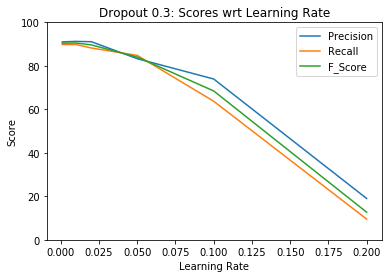

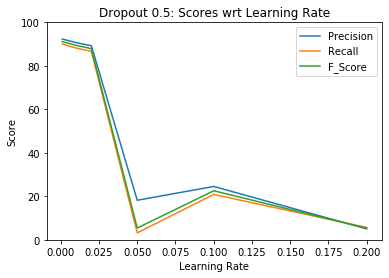

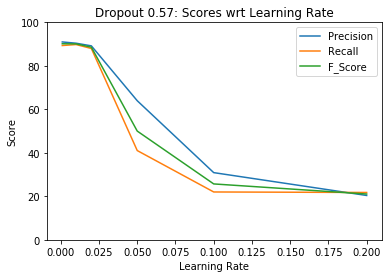

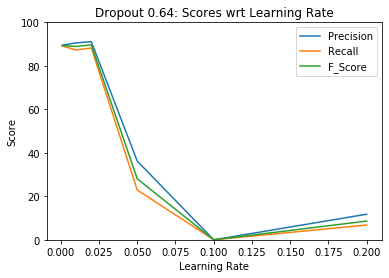

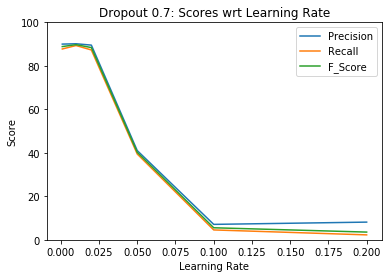

In [ ]:
#no_test

print('Plot columns wrt same dropout, different learning rates')
my_lr = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]
my_dps = [0.3, 0.5, 0.57, 0.64, 0.7]

plt.figure(1)
#plt.subplot(511)
plt.ylim([0, 100])
dps3_precision = dps3['Precision'].tolist()
dps3_recall = dps3['Recall'].tolist()
dps3_f = dps3['F_Score'].tolist()
plt.plot(my_lr, dps3_precision, label='Precision')
plt.plot(my_lr, dps3_recall, label='Recall')
plt.plot(my_lr, dps3_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Dropout 0.3: Scores wrt Learning Rate')
plt.legend()
plt.show()

plt.figure(2)
#plt.subplot(511)
plt.ylim([0, 100])
dps5_precision = dps5['Precision'].tolist()
dps5_recall = dps5['Recall'].tolist()
dps5_f = dps5['F_Score'].tolist()
plt.plot(my_lr, dps5_precision, label='Precision')
plt.plot(my_lr, dps5_recall, label='Recall')
plt.plot(my_lr, dps5_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Dropout 0.5: Scores wrt Learning Rate')
plt.legend()
plt.show()

plt.figure(3)
#plt.subplot(511)
plt.ylim([0, 100])
dps57_precision = dps57['Precision'].tolist()
dps57_recall = dps57['Recall'].tolist()
dps57_f = dps57['F_Score'].tolist()
plt.plot(my_lr, dps57_precision, label='Precision')
plt.plot(my_lr, dps57_recall, label='Recall')
plt.plot(my_lr, dps57_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Dropout 0.57: Scores wrt Learning Rate')
plt.legend()
plt.show()

plt.figure(4)
#plt.subplot(511)
plt.ylim([0, 100])
dps64_precision = dps64['Precision'].tolist()
dps64_recall = dps64['Recall'].tolist()
dps64_f = dps64['F_Score'].tolist()
plt.plot(my_lr, dps64_precision, label='Precision')
plt.plot(my_lr, dps64_recall, label='Recall')
plt.plot(my_lr, dps64_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Dropout 0.64: Scores wrt Learning Rate')
plt.legend()
plt.show()

plt.figure(5)
#plt.subplot(511)
plt.ylim([0, 100])
dps7_precision = dps7['Precision'].tolist()
dps7_recall = dps7['Recall'].tolist()
dps7_f = dps7['F_Score'].tolist()
plt.plot(my_lr, dps7_precision, label='Precision')
plt.plot(my_lr, dps7_recall, label='Recall')
plt.plot(my_lr, dps7_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Dropout 0.7: Scores wrt Learning Rate')
plt.legend()
plt.show()

It appears as though we can ignore learning rates above 0.03 or so, so let's focus on that

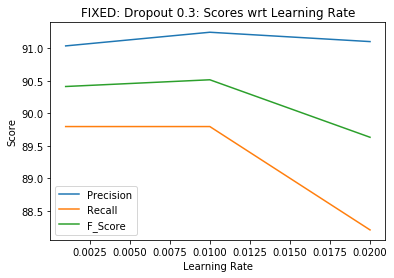

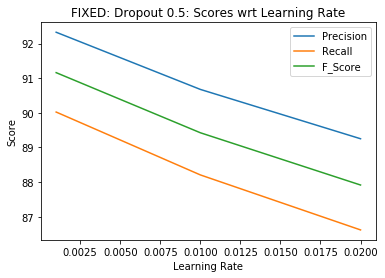

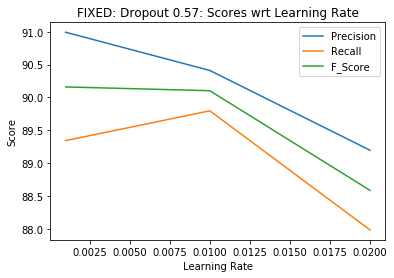

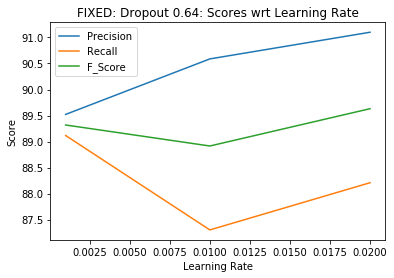

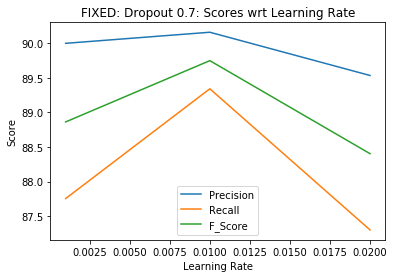

In [ ]:
#no_test

my_lr = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]
my_dps = [0.3, 0.5, 0.57, 0.64, 0.7]

#Selecting trials where the Learning_Rate is greater than some desired value
#min_lr = 0.03
#my_lr = [i for i in my_lr if i >= min_lr]

max_lr = 0.03
my_lr = [i for i in my_lr if i <= max_lr]

dps3f = dps3.loc[dps3['Learning_Rate'] <= max_lr]
dps5f = dps5.loc[dps5['Learning_Rate'] <= max_lr]
dps57f = dps57.loc[dps57['Learning_Rate'] <= max_lr]
dps64f = dps64.loc[dps64['Learning_Rate'] <= max_lr]
dps7f = dps7.loc[dps7['Learning_Rate'] <= max_lr]

#Plotting again
plt.figure(1)
#plt.subplot(511)
dps3f_precision = dps3f['Precision'].tolist()
dps3f_recall = dps3f['Recall'].tolist()
dps3f_f = dps3f['F_Score'].tolist()
plt.plot(my_lr, dps3f_precision, label='Precision')
plt.plot(my_lr, dps3f_recall, label='Recall')
plt.plot(my_lr, dps3f_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('FIXED: Dropout 0.3: Scores wrt Learning Rate')
plt.legend()
plt.show()

plt.figure(2)
#plt.subplot(511)
dps5f_precision = dps5f['Precision'].tolist()
dps5f_recall = dps5f['Recall'].tolist()
dps5f_f = dps5f['F_Score'].tolist()
plt.plot(my_lr, dps5f_precision, label='Precision')
plt.plot(my_lr, dps5f_recall, label='Recall')
plt.plot(my_lr, dps5f_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('FIXED: Dropout 0.5: Scores wrt Learning Rate')
plt.legend()
plt.show()

plt.figure(3)
#plt.subplot(511)
dps57f_precision = dps57f['Precision'].tolist()
dps57f_recall = dps57f['Recall'].tolist()
dps57f_f = dps57f['F_Score'].tolist()
plt.plot(my_lr, dps57f_precision, label='Precision')
plt.plot(my_lr, dps57f_recall, label='Recall')
plt.plot(my_lr, dps57f_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('FIXED: Dropout 0.57: Scores wrt Learning Rate')
plt.legend()
plt.show()

plt.figure(4)
#plt.subplot(511)
dps64f_precision = dps64f['Precision'].tolist()
dps64f_recall = dps64f['Recall'].tolist()
dps64f_f = dps64f['F_Score'].tolist()
plt.plot(my_lr, dps64f_precision, label='Precision')
plt.plot(my_lr, dps64f_recall, label='Recall')
plt.plot(my_lr, dps64f_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('FIXED: Dropout 0.64: Scores wrt Learning Rate')
plt.legend()
plt.show()

plt.figure(5)
#plt.subplot(511)
dps7f_precision = dps7f['Precision'].tolist()
dps7f_recall = dps7f['Recall'].tolist()
dps7f_f = dps7f['F_Score'].tolist()
plt.plot(my_lr, dps7f_precision, label='Precision')
plt.plot(my_lr, dps7f_recall, label='Recall')
plt.plot(my_lr, dps7f_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('FIXED: Dropout 0.7: Scores wrt Learning Rate')
plt.legend()
plt.show()



Repeating the above with respect to learning rate.  Note that we expect the lower learning rates to have the best scores

Plot columns wrt same learning rates, different dropout


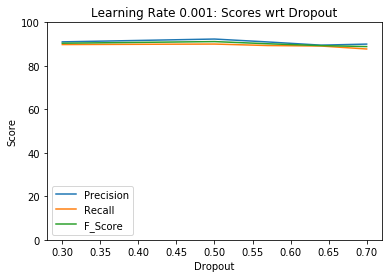

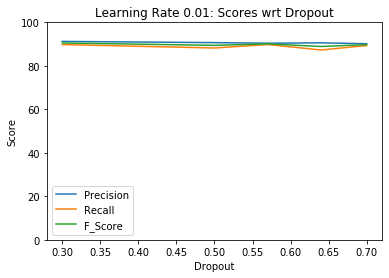

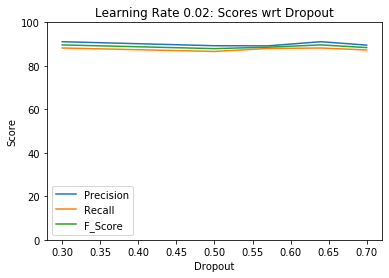

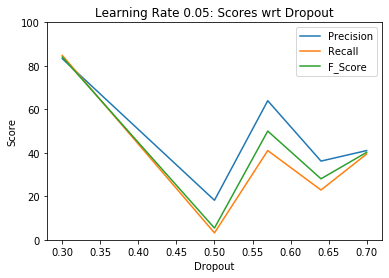

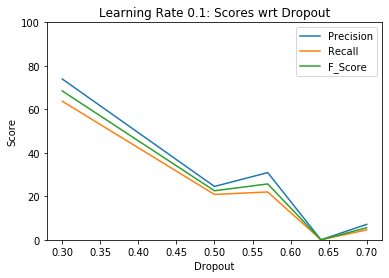

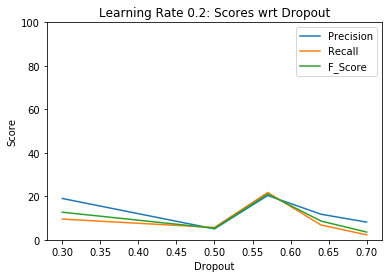

In [ ]:
#no_test

my_lr = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]
my_dps = [0.3, 0.5, 0.57, 0.64, 0.7]

print('Plot columns wrt same learning rates, different dropout')
plt.figure(1)
#plt.subplot(511)
plt.ylim([0, 100])
lr001_precision = lr001['Precision'].tolist()
lr001_recall = lr001['Recall'].tolist()
lr001_f = lr001['F_Score'].tolist()
plt.plot(my_dps, lr001_precision, label='Precision')
plt.plot(my_dps, lr001_recall, label='Recall')
plt.plot(my_dps, lr001_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.001: Scores wrt Dropout')
plt.legend()
plt.show()

plt.figure(2)
#plt.subplot(511)
plt.ylim([0, 100])
lr01_precision = lr01['Precision'].tolist()
lr01_recall = lr01['Recall'].tolist()
lr01_f = lr01['F_Score'].tolist()
plt.plot(my_dps, lr01_precision, label='Precision')
plt.plot(my_dps, lr01_recall, label='Recall')
plt.plot(my_dps, lr01_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.01: Scores wrt Dropout')
plt.legend()
plt.show()

plt.figure(3)
#plt.subplot(511)
plt.ylim([0, 100])
lr02_precision = lr02['Precision'].tolist()
lr02_recall = lr02['Recall'].tolist()
lr02_f = lr02['F_Score'].tolist()
plt.plot(my_dps, lr02_precision, label='Precision')
plt.plot(my_dps, lr02_recall, label='Recall')
plt.plot(my_dps, lr02_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.02: Scores wrt Dropout')
plt.legend()
plt.show()

plt.figure(4)
#plt.subplot(511)
plt.ylim([0, 100])
lr05_precision = lr05['Precision'].tolist()
lr05_recall = lr05['Recall'].tolist()
lr05_f = lr05['F_Score'].tolist()
plt.plot(my_dps, lr05_precision, label='Precision')
plt.plot(my_dps, lr05_recall, label='Recall')
plt.plot(my_dps, lr05_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.05: Scores wrt Dropout')
plt.legend()
plt.show()

plt.figure(5)
#plt.subplot(511)
plt.ylim([0, 100])
lr1_precision = lr1['Precision'].tolist()
lr1_recall = lr1['Recall'].tolist()
lr1_f = lr1['F_Score'].tolist()
plt.plot(my_dps, lr1_precision, label='Precision')
plt.plot(my_dps, lr1_recall, label='Recall')
plt.plot(my_dps, lr1_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.1: Scores wrt Dropout')
plt.legend()
plt.show()

plt.figure(6)
#plt.subplot(511)
plt.ylim([0, 100])
lr2_precision = lr2['Precision'].tolist()
lr2_recall = lr2['Recall'].tolist()
lr2_f = lr2['F_Score'].tolist()
plt.plot(my_dps, lr2_precision, label='Precision')
plt.plot(my_dps, lr2_recall, label='Recall')
plt.plot(my_dps, lr2_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.2: Scores wrt Dropout')
plt.legend()
plt.show()


Again, let's only focus on the cases with usuable performance

Plot columns wrt same learning rates, different dropout


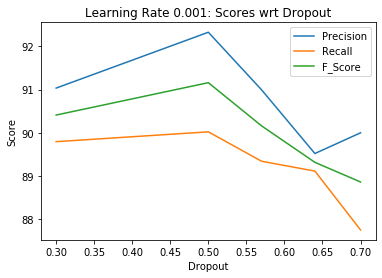

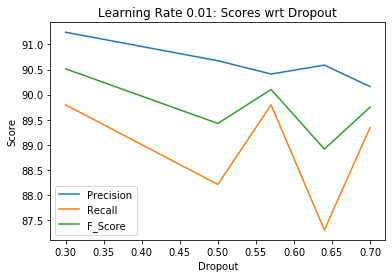

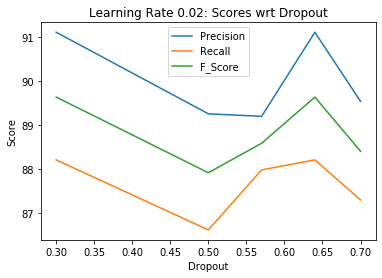

In [ ]:
#no_test

my_lr = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]
my_dps = [0.3, 0.5, 0.57, 0.64, 0.7]

print('Plot columns wrt same learning rates, different dropout')
plt.figure(1)
#plt.subplot(511)
lr001_precision = lr001['Precision'].tolist()
lr001_recall = lr001['Recall'].tolist()
lr001_f = lr001['F_Score'].tolist()
plt.plot(my_dps, lr001_precision, label='Precision')
plt.plot(my_dps, lr001_recall, label='Recall')
plt.plot(my_dps, lr001_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.001: Scores wrt Dropout')
plt.legend()
plt.show()

plt.figure(2)
#plt.subplot(511)
lr01_precision = lr01['Precision'].tolist()
lr01_recall = lr01['Recall'].tolist()
lr01_f = lr01['F_Score'].tolist()
plt.plot(my_dps, lr01_precision, label='Precision')
plt.plot(my_dps, lr01_recall, label='Recall')
plt.plot(my_dps, lr01_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.01: Scores wrt Dropout')
plt.legend()
plt.show()

plt.figure(3)
#plt.subplot(511)
lr02_precision = lr02['Precision'].tolist()
lr02_recall = lr02['Recall'].tolist()
lr02_f = lr02['F_Score'].tolist()
plt.plot(my_dps, lr02_precision, label='Precision')
plt.plot(my_dps, lr02_recall, label='Recall')
plt.plot(my_dps, lr02_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.02: Scores wrt Dropout')
plt.legend()
plt.show()

In [ ]:
#no_test

#This block hasn't been written yet, will do the above but as a callable function
#Note that history_df is wrong, needs to be updated on every run, not just overwriting a new copy...

#load saved model and performance metrics if desired:
#this_model_dir = 'models/42-initial-model/4e0f496_dp0.4_lr0.0003'
#nlp_model = load_model(this_model_dir)
#perf_df = read_csv(this_model_dir + '\perf_df.csv')

#perf_df.set_index('cycle_no', drop=True, inplace=True)
#perf_df.head()

#Plotting
#Columns: cycle_no avg_cycle_loss precission recall f_score dropout learning_rate

#Note that training curves already exist in NB 42:

#scale the losses a bit just to see things together
#perf_df['loss_scaled'] = perf_df['avg_cycle_loss']/10
#perf_df.drop(columns=['avg_cycle_loss']).plot()

In [ ]:
#no_test

from nbdev.export import notebook2script
notebook2script()

Converted 12-ssda-xml-parser.ipynb.
Converted 31-collate-xml-entities-spans.ipynb.
Converted 33-split-data.ipynb.
Converted 41-generic-framework-for-spacy-training.ipynb.
Converted 42-initial-model.ipynb.
Converted 51-data-preprocessing.ipynb.
Converted 52-unstructured-to-markup.ipynb.
Converted 53-markup-to-spatial-historian.ipynb.
Converted 54-utility-functions.ipynb.
Converted 61-prodigy-output-training-demo.ipynb.
Converted 62-full-model-application-demo.ipynb.
Converted 63-pt-model-training.ipynb.
Converted 64-es-model-training.ipynb.
Converted 65-all-annotations-model-training.ipynb.
Converted 66-es-guatemala-model-training.ipynb.
Converted 67-death-and-birth-records-together.ipynb.
Converted 70-exhaustive-training.ipynb.
Converted 71-relationship-builder.ipynb.
Converted 72-full-volume-processor.ipynb.
